<a href="https://colab.research.google.com/github/ritwiks9635/Image_Captioning/blob/main/Image_Captioning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Image Captioning Model**

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/adityajn105/flickr8k/flickr8k.zip

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from textwrap import wrap

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
img_path = "/content/Images"
text_path = "/content/captions.txt"

df = pd.read_csv(text_path)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [5]:
def load_img(img_path, img_size = 224):
    image = keras.utils.load_img(img_path, target_size = (img_size, img_size))
    image = keras.utils.img_to_array(image)
    image = image / 255.0
    return image

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = load_img(os.path.join(img_path, temp_df.image[i]))
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

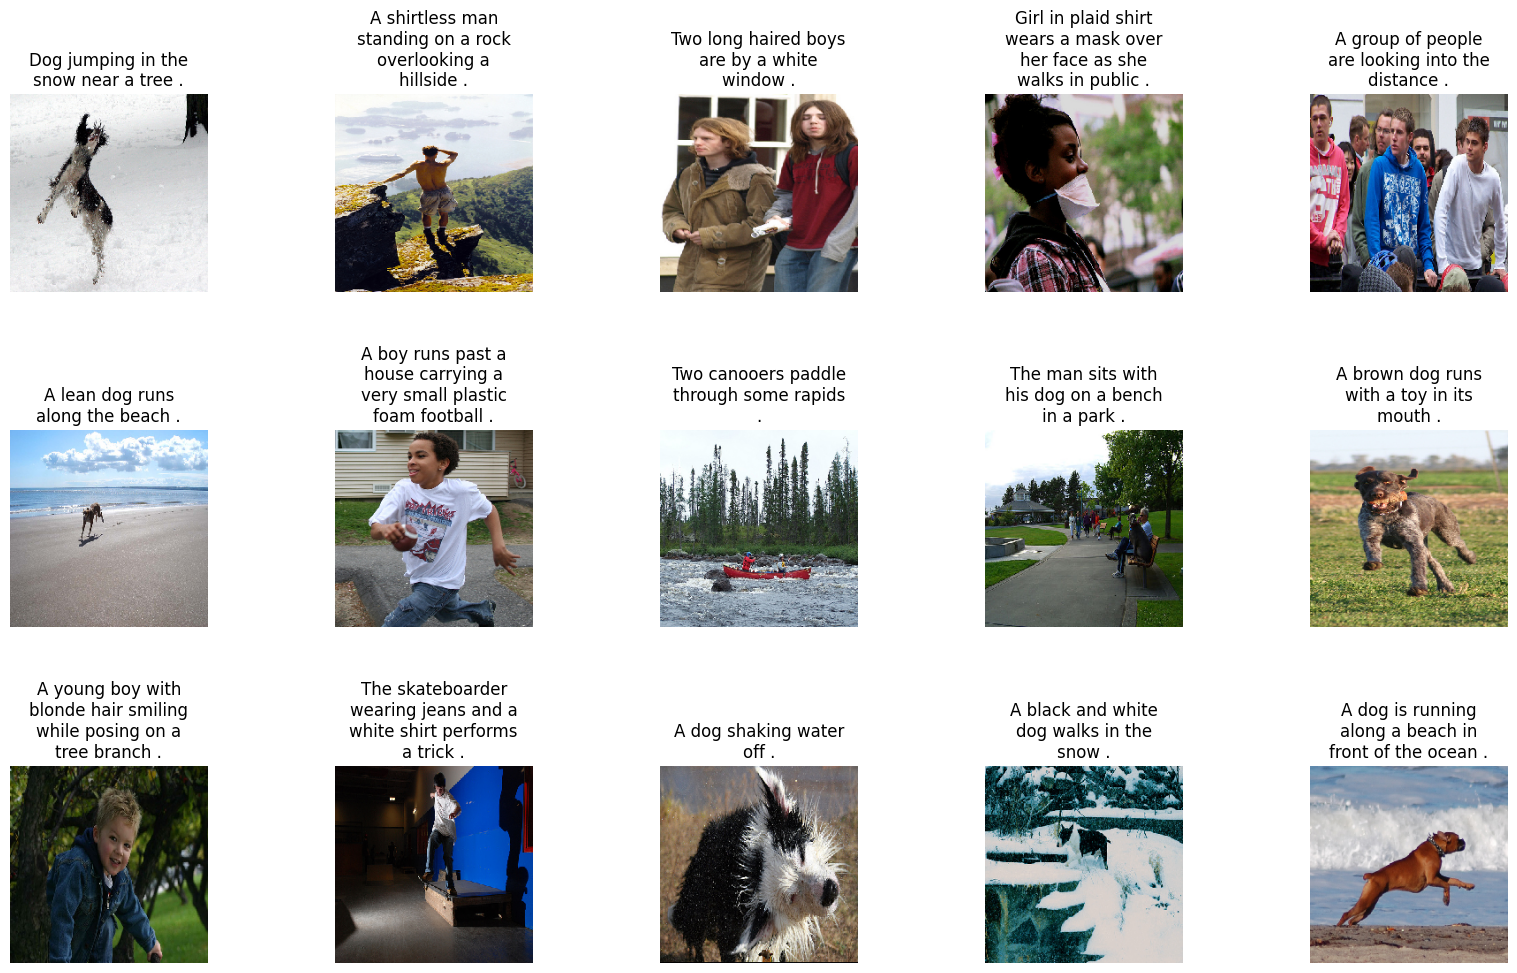

In [6]:
display_images(df.sample(15))

In [7]:
def text_preprocessing(df):
    df['caption'] = df['caption'].apply(lambda x: x.lower())
    df['caption'] = df['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    df['caption'] = df['caption'].apply(lambda x: x.replace("\s+"," "))
    df['caption'] = df['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    df['caption'] = "<start> " + df['caption'] + " <end>"
    return df

In [8]:
data = text_preprocessing(df)
caption = data["caption"].tolist()
caption[:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [9]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(caption)
vocab_size = len(tokenizer.word_index) + 1
max_token = max(len(cap.split()) for cap in caption)

images = data["image"].unique().tolist()
n_images = len(images)

split_index = int(0.85 * n_images)
train_img = images[: split_index]
test_img = images[split_index :]

train_data = data[data["image"].isin(train_img)]
test_data = data[data["image"].isin(test_img)]
print("Total train data is :: ", len(train_data))
print("Total test data is :: ", len(test_data))

train_data.reset_index(inplace = True, drop = True)
test_data.reset_index(inplace = True, drop = True)

Total train data is ::  34385
Total test data is ::  6070


In [10]:
tokenizer.texts_to_sequences([caption[3]])

[[2, 39, 18, 118, 4, 393, 19, 59, 2426, 1]]

In [11]:
model = keras.applications.DenseNet201()
feature_extractor = keras.Model(inputs = model.input, outputs = model.layers[-2].output)
img_size = 224
features = {}

for image_path in tqdm(data["image"].unique().tolist()):
    image = keras.utils.load_img(os.path.join(img_path, image_path), target_size = (img_size, img_size))
    image = keras.utils.img_to_array(image)
    image = image / 255.0
    image = np.expand_dims(image, axis = 0)
    feature = feature_extractor.predict(image, verbose = 0)
    features[image_path] = feature

82524592/82524592 [==============================] - 6s 0us/step


100%|██████████| 8091/8091 [15:32<00:00,  8.68it/s]


In [12]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = keras.utils.to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [13]:
train_generator = DataGenerator(df = train_data, X_col = 'image', y_col = 'caption', batch_size = 64, directory = img_path,
                               tokenizer = tokenizer, vocab_size = vocab_size, max_length = max_token,features = features)

valid_generator = DataGenerator(df = test_data, X_col = 'image', y_col = 'caption', batch_size = 64, directory = img_path,
                               tokenizer = tokenizer, vocab_size = vocab_size, max_length = max_token,features = features)

In [35]:
input1 = keras.Input(shape=(1920,))
input2 = keras.Input(shape=(max_token,))

img_features = layers.Dense(256, activation='relu')(input1)
img_features_reshaped = layers.Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = layers.Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = layers.concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = layers.LSTM(256)(merged)
x = layers.Dropout(0.5)(sentence_features)
x = layers.add([x, img_features])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(vocab_size, activation='softmax')(x)

caption_model = keras.Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [39]:
caption_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1920)]               0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 256)                  491776    ['input_5[0][0]']             
                                                                                                  
 input_6 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 1, 256)               0         ['dense_3[0][0]']             
                                                                                            

In [40]:
checkpoint_path = "caption_model.h5"
checkpoint_callbacks = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    min_delta = 0,
    restore_best_weights = True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    patience = 3,
    factor = 0.2,
    min_lr = 0.0000001)

callbacks = [checkpoint_callbacks, early_stopping_cb, reduce_lr]

In [41]:
history = caption_model.fit(
    train_generator,
    epochs = 50,
    validation_data = valid_generator,
    callbacks = callbacks)

Epoch 1/50
537/537 [==============================] - 74s 132ms/step - loss: 5.1150 - val_loss: 4.2834 - lr: 0.0010
Epoch 2/50
537/537 [==============================] - 56s 105ms/step - loss: 4.2552 - val_loss: 3.9571 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - 53s 98ms/step - loss: 3.9778 - val_loss: 3.8021 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - 55s 102ms/step - loss: 3.8036 - val_loss: 3.7120 - lr: 0.0010
Epoch 5/50
537/537 [==============================] - 52s 97ms/step - loss: 3.6770 - val_loss: 3.6680 - lr: 0.0010
Epoch 6/50
537/537 [==============================] - 57s 106ms/step - loss: 3.5751 - val_loss: 3.6398 - lr: 0.0010
Epoch 7/50
537/537 [==============================] - 52s 97ms/step - loss: 3.4983 - val_loss: 3.6304 - lr: 0.0010
Epoch 8/50
537/537 [==============================] - 54s 101ms/step - loss: 3.4288 - val_loss: 3.6214 - lr: 0.0010
Epoch 9/50
537/537 [==============================] - 52s 96ms/step - loss:

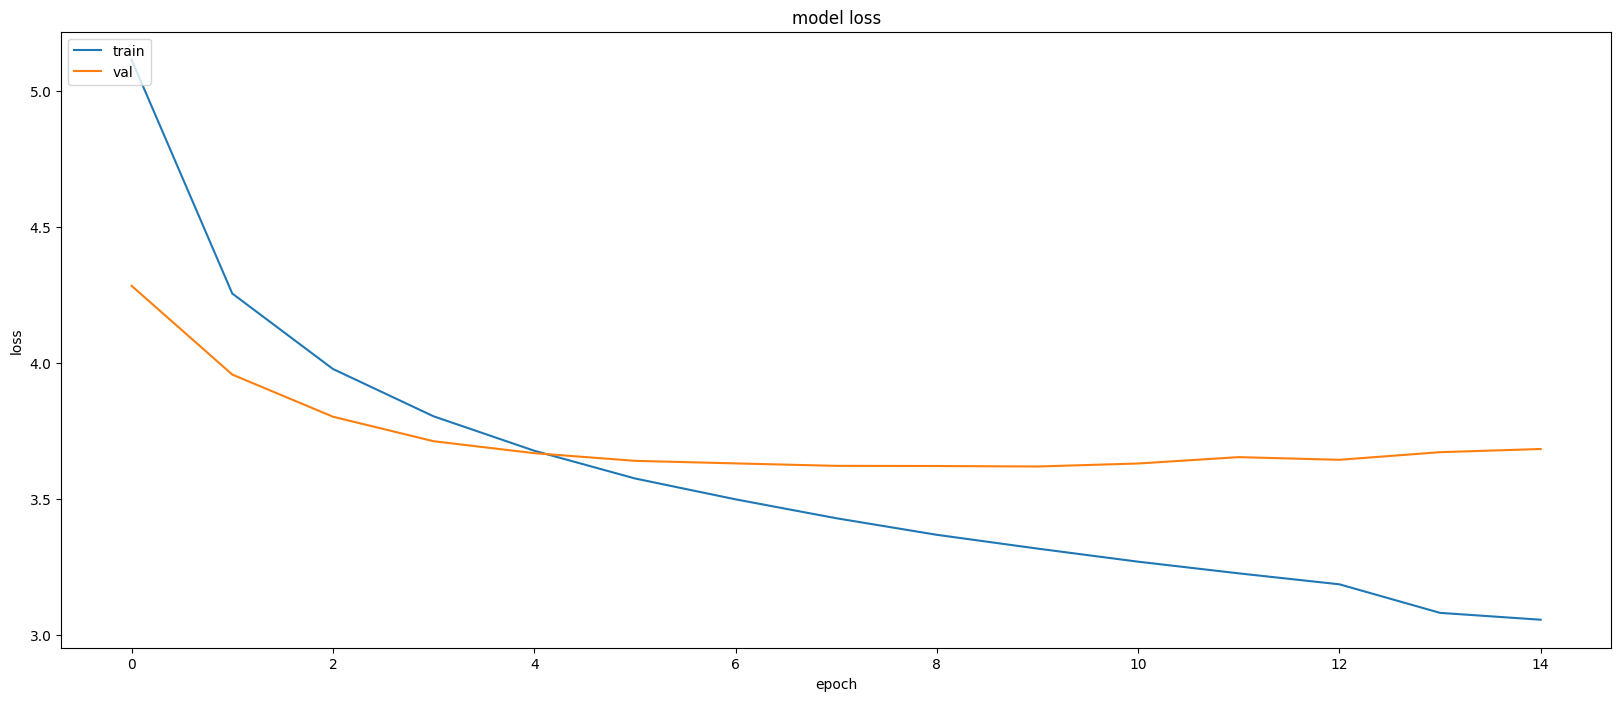

In [42]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "<start> "
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = keras.preprocessing.sequence.pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
samples = test_data.sample(15)
samples.reset_index(drop=True,inplace=True)

for index,record in samples.iterrows():

    img = keras.utils.load_img(os.path.join(img_path, record['image']),target_size=(224,224))
    img = keras.utils.img_to_array(img)
    img = img/255.

    caption = predict_caption(model = caption_model, image = record['image'], tokenizer = tokenizer, max_length = max_token, features = features)
    samples.loc[index,'caption'] = caption

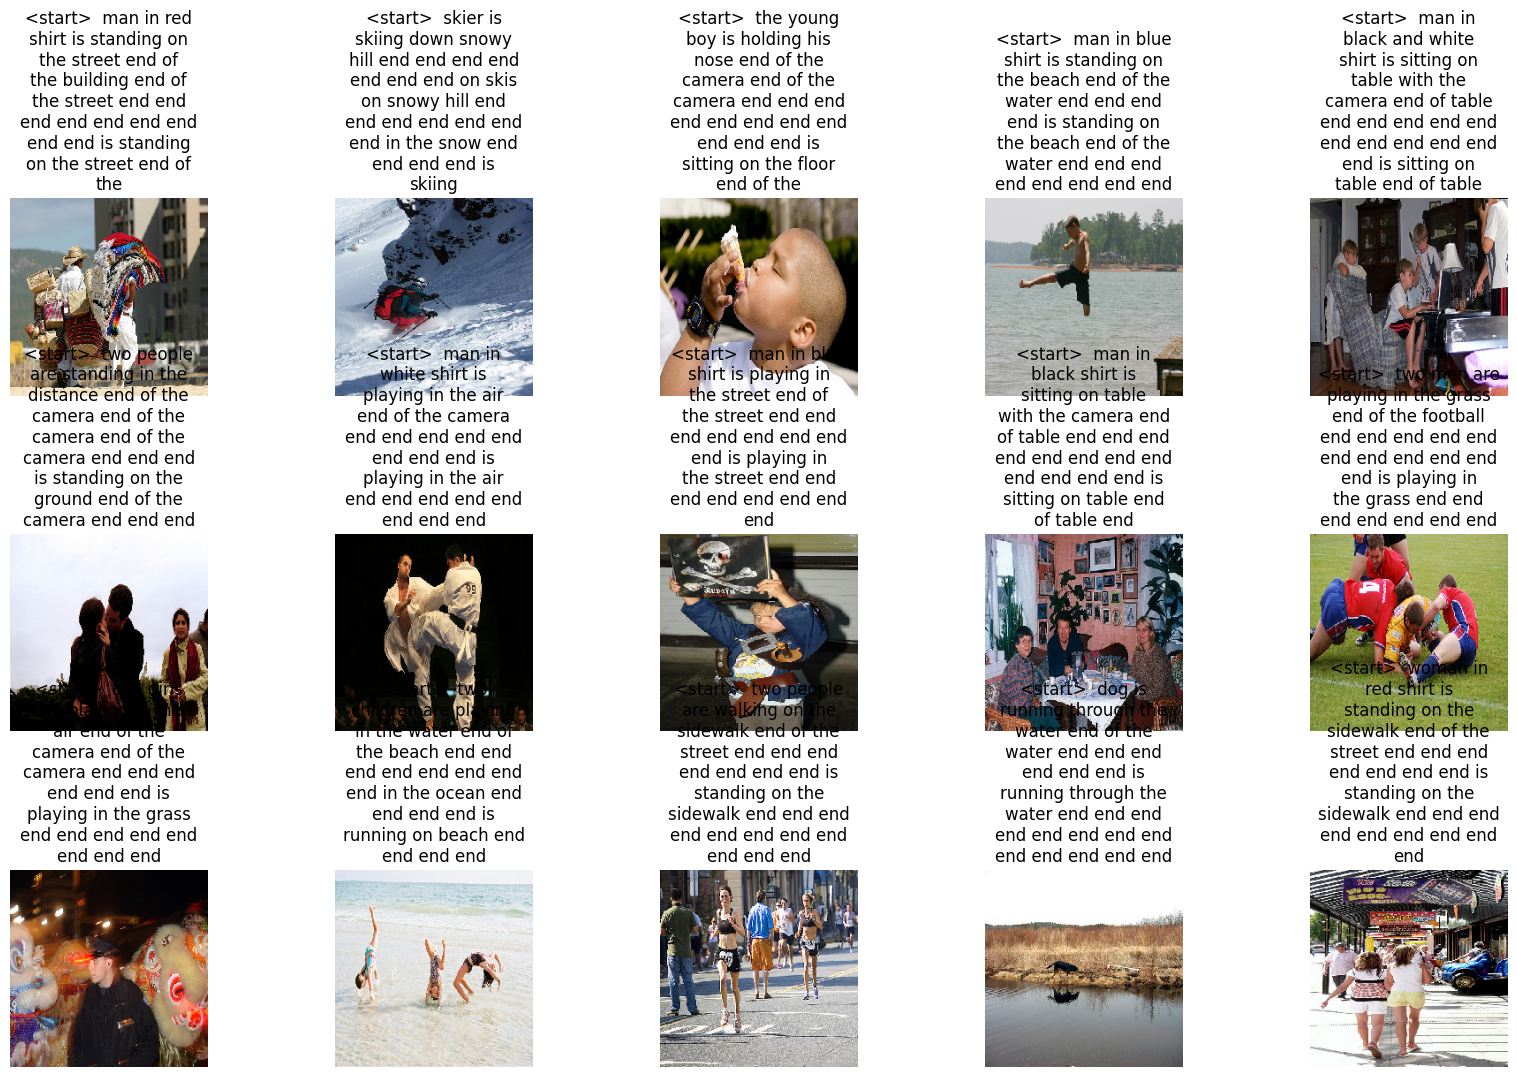

In [45]:
display_images(samples)